# Using PyTorch

In the previous notebooks we haven't really levereaged much of PyTorch. Here lets get a feel for how we could create our MLP in PyTorch.

We will be working off of [this example](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html).

**Note: This notebook is not easy to follow, I was doing a lot of trial and error. We will work through this more cleanly in a future notebook**

In [39]:
import pandas as pd
import time
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

PADDING_TOKEN_INDEX = 0
PAD_TO_SIZE = 50

class CrosswordClueAnswersDataset(Dataset):
    """Crossword clues and answers dataset."""

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with clues and answers.
        """
        self.values = pd.read_csv(csv_file, keep_default_na=False).values
        
    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.values[idx, :]
        return (data[0], data[1])

class CrosswordModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, padding_size, hidden_size, num_class, device):
        super(CrosswordModel, self).__init__()
        self.C = torch.nn.Embedding(vocab_size, embed_dim, device=device)
        self.W1 = torch.nn.Linear(embed_dim * padding_size, hidden_size, device=device)
        self.W2 = torch.nn.Linear(hidden_size, num_class, device=device)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.C.weight.data.uniform_(-initrange, initrange)
        self.W1.weight.data.uniform_(-initrange, initrange)
        self.W1.bias.data.zero_()
        self.W2.weight.data.uniform_(-initrange, initrange)
        self.W2.bias.data.zero_()

    def forward(self, text):
        emb = self.C(text)
        h = torch.tanh(self.W1(emb.view(-1, self.W1.in_features)))
        return self.W2(h)

def yield_clues(data_iter):
    for _, clue in data_iter:
        yield tokenizer(clue)

def yield_answers(data_iter):
    for answer, _ in data_iter:
        yield tokenizer(answer)
        
def collate_batch(batch):
    answer_list, clue_list = [], []
    
    # need to understand the offsets, cumsum, and cat
    # need to add padding
    
    for (answer, clue) in batch:
        clue_indicies = clue_pipeline(clue)
        clue_indicies += [PADDING_TOKEN_INDEX] * (PAD_TO_SIZE - len(clue_indicies))
        clue_list.append(clue_indicies)
        
        answer_list.append(answer_pipeline(answer))
        
    answer_list = torch.tensor(answer_list)
    clue_list = torch.tensor(clue_list)
    
    return answer_list.to(device), clue_list.to(device)

# !!! This seems slower anyway !!! - not even sure my code is working though
# attempt to run on mps - will do work on the GPU for MacOS
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#print(f'Running on:', device)
device = 'cpu'

In [2]:
%%time
# load dataset, split data
dataset = CrosswordClueAnswersDataset("cleaned_data/clean_2.csv")
train_size = int(0.8 * len(dataset))
dev_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - dev_size
train_dataset, test_dataset, dev_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, dev_size])
print(f'{len(dataset)=}\n{len(train_dataset)=}\n{len(test_dataset)=}\n{len(dev_dataset)=}\n')

# build vocabulary
tokenizer = get_tokenizer('basic_english')
answers_vocab = build_vocab_from_iterator(yield_answers(train_dataset), specials=['<unk>'])
answers_vocab.set_default_index(0)
clues_vocab = build_vocab_from_iterator(yield_clues(train_dataset), specials=['<pad>', '<unk>'])
clues_vocab.set_default_index(1)

clue_pipeline = lambda x: clues_vocab(tokenizer(x))
answer_pipeline = lambda x: answers_vocab([x])[0]

len(dataset)=770361
len(train_dataset)=616288
len(test_dataset)=77037
len(dev_dataset)=77036

CPU times: user 4.27 s, sys: 58 ms, total: 4.33 s
Wall time: 4.33 s


In [42]:
def train(model, optimizer, criterion, dataloader, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (answer, clue) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_answer = model(clue)
        loss = criterion(predicted_answer, answer)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_answer.argmax(1) == answer).sum().item()
        total_count += answer.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, criterion, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (answer, clue) in enumerate(dataloader):
            predicted_answer = model(clue)
            loss = criterion(predicted_answer, answer)
            total_acc += (predicted_answer.argmax(1) == answer).sum().item()
            total_count += answer.size(0)
    return total_acc/total_count

def run_epoch(hyperparameters):    
    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters['BATCH_SIZE'], shuffle=True, collate_fn=collate_batch)
    dev_dataloader = DataLoader(dev_dataset, batch_size=hyperparameters['BATCH_SIZE'], shuffle=True, collate_fn=collate_batch)

    num_class = len(answers_vocab)
    vocab_size = len(clues_vocab)
    model = CrosswordModel(vocab_size, hyperparameters['EMBEDDING_LAYER_SIZE'], PAD_TO_SIZE, hyperparameters['HIDDEN_SIZE'], num_class, device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['LR'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    total_accu = None

    for epoch in range(1, hyperparameters['EPOCHS'] + 1):
        epoch_start_time = time.time()
        train(model, optimizer, criterion, train_dataloader, epoch)
        accu_val = evaluate(model, criterion, dev_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
        else:
            total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'valid accuracy {:8.3f} '.format(epoch,
                                               time.time() - epoch_start_time,
                                               accu_val))
        print('-' * 59)
    
    torch.save(model.state_dict(), 'model2.pt')
    return accu_val

In [23]:
params = []
accu_vals = []

In [24]:
HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 10
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 20
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 40
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 80
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 160
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 320
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 640
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 1280
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 2560
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

HYPERPARAMETERS = {
    'EPOCHS': 5,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 5120
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

{'EPOCHS': 5, 'LR': 5, 'BATCH_SIZE': 64, 'EMBEDDING_LAYER_SIZE': 16, 'HIDDEN_SIZE': 10}
| epoch   1 |   500/ 9630 batches | accuracy    0.000
| epoch   1 |  1000/ 9630 batches | accuracy    0.001
| epoch   1 |  1500/ 9630 batches | accuracy    0.001
| epoch   1 |  2000/ 9630 batches | accuracy    0.001
| epoch   1 |  2500/ 9630 batches | accuracy    0.001
| epoch   1 |  3000/ 9630 batches | accuracy    0.001
| epoch   1 |  3500/ 9630 batches | accuracy    0.001
| epoch   1 |  4000/ 9630 batches | accuracy    0.001
| epoch   1 |  4500/ 9630 batches | accuracy    0.001
| epoch   1 |  5000/ 9630 batches | accuracy    0.001
| epoch   1 |  5500/ 9630 batches | accuracy    0.001
| epoch   1 |  6000/ 9630 batches | accuracy    0.001
| epoch   1 |  6500/ 9630 batches | accuracy    0.002
| epoch   1 |  7000/ 9630 batches | accuracy    0.001
| epoch   1 |  7500/ 9630 batches | accuracy    0.002
| epoch   1 |  8000/ 9630 batches | accuracy    0.002
| epoch   1 |  8500/ 9630 batches | accuracy    

KeyboardInterrupt: 

In [43]:
HYPERPARAMETERS = {
    'EPOCHS': 150,
    'LR': 5,
    'BATCH_SIZE': 64,
    'EMBEDDING_LAYER_SIZE': 16,
    'HIDDEN_SIZE': 80
}
print(HYPERPARAMETERS)
accu_val = run_epoch(HYPERPARAMETERS)
params.append(HYPERPARAMETERS)
accu_vals.append(accu_val)

{'EPOCHS': 150, 'LR': 5, 'BATCH_SIZE': 64, 'EMBEDDING_LAYER_SIZE': 16, 'HIDDEN_SIZE': 80}
| epoch   1 |   500/ 9630 batches | accuracy    0.000
| epoch   1 |  1000/ 9630 batches | accuracy    0.000
| epoch   1 |  1500/ 9630 batches | accuracy    0.000
| epoch   1 |  2000/ 9630 batches | accuracy    0.000
| epoch   1 |  2500/ 9630 batches | accuracy    0.000
| epoch   1 |  3000/ 9630 batches | accuracy    0.000
| epoch   1 |  3500/ 9630 batches | accuracy    0.001
| epoch   1 |  4000/ 9630 batches | accuracy    0.001
| epoch   1 |  4500/ 9630 batches | accuracy    0.001
| epoch   1 |  5000/ 9630 batches | accuracy    0.001
| epoch   1 |  5500/ 9630 batches | accuracy    0.001
| epoch   1 |  6000/ 9630 batches | accuracy    0.001
| epoch   1 |  6500/ 9630 batches | accuracy    0.001
| epoch   1 |  7000/ 9630 batches | accuracy    0.001
| epoch   1 |  7500/ 9630 batches | accuracy    0.002
| epoch   1 |  8000/ 9630 batches | accuracy    0.002
| epoch   1 |  8500/ 9630 batches | accuracy  

[10, 20, 40, 80, 160, 320, 640, 1280, 2560, 80, 80, 80]


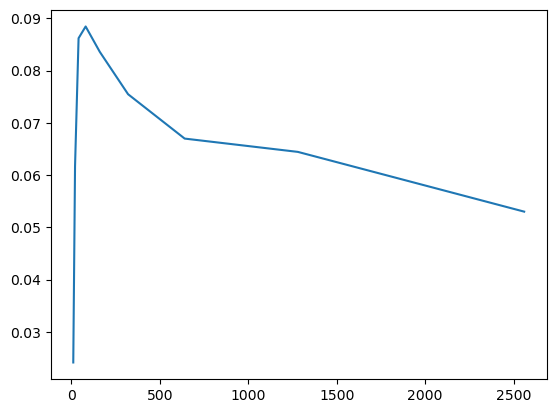

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

sizes = list(map(lambda x: x['HIDDEN_SIZE'], params))
print(sizes)
plt.plot(sizes[:-3], accu_vals[:-3])

Interesting the impact of increasing the neurons has very quickly. Also interesting how quickly the dropoff is. The dropoff could be a result of more parameters taking longer to train (learning rate was constant), but I'm not sure of that.